# 5-class-Consumer-Complaints classification by multilingual BERT


## 1.Import library

In [ ]:
!nvidia-smi

Sat Apr 16 03:05:24 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    25W / 300W |      0MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!pip3 install tensorflow_text>=2.0.0rc0

In [ ]:
!pip install pandas_summary

In [ ]:
import os
import h5py
import time
import glob
import json
import csv
import datetime
import random
import string
import pickle
import imageio
import cv2
import re
import sys
from tqdm import tqdm_notebook
from PIL import Image
import numpy as np
import pandas as pd

import tensorflow as tf
import tensorflow_hub as hub
from tensorflow import keras
import tensorflow_text as text 
from tensorflow.keras import layers, Sequential, Input
from tensorflow.keras.preprocessing.image import load_img, img_to_array, array_to_img
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Lambda, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn import preprocessing
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import VarianceThreshold
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import KFold, StratifiedKFold

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.cm as cm

from IPython.display import Image
%matplotlib inline

tf.random.set_seed(200) 

tf.__version__

'2.8.0'

## 2. Import text data 

In [ ]:
df = pd.read_csv('complaints.csv')
df.head()

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (9) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID
0,2022-04-13,"Credit reporting, credit repair services, or o...",Other personal consumer report,Incorrect information on your report,Public record information inaccurate,NaN,NaN,"EQUIFAX, INC.",GA,30034.0,NaN,NaN,Web,2022-04-13,In progress,Yes,NaN,5441680
1,2022-04-07,Debt collection,Medical debt,Attempts to collect debt not owed,Debt is not yours,NaN,Company believes it acted appropriately as aut...,"Advanced Collection Bureau, Inc.",FL,34786.0,NaN,NaN,Web,2022-04-07,Closed with explanation,Yes,NaN,5418712
2,2022-04-06,"Credit reporting, credit repair services, or o...",Credit reporting,Improper use of your report,Reporting company used your report improperly,NaN,Company has responded to the consumer and the ...,Experian Information Solutions Inc.,LA,70563.0,NaN,Consent not provided,Web,2022-04-06,Closed with explanation,Yes,NaN,5415148
3,2022-04-07,"Credit reporting, credit repair services, or o...",Credit reporting,Incorrect information on your report,Information belongs to someone else,NaN,NaN,NAVY FEDERAL CREDIT UNION,CA,92105.0,Servicemember,NaN,Phone,2022-04-07,In progress,Yes,NaN,5418975
4,2022-04-06,"Credit reporting, credit repair services, or o...",Credit reporting,Incorrect information on your report,Information belongs to someone else,NaN,Company has responded to the consumer and the ...,Experian Information Solutions Inc.,IN,46256.0,NaN,NaN,Web,2022-04-06,Closed with explanation,Yes,NaN,5415270


In [ ]:
from pandas_summary import DataFrameSummary
DataFrameSummary(df).summary()

,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID
count,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2599806.0
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3080740.043382
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1397717.14202
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2146518.75
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3253548.5
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4089374.75
max,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5450919.0
counts,2599806,2599806,2364643,2599806,1944278,910187,1079134,2599806,2560423,2560169,306437,1835061,2599806,2599806,2599803,2599806,768458,2599806
uniques,3787,18,76,165,221,809769,11,6344,63,58836,3,4,7,3736,8,2,2,2599806


## 3. Preparing data for classification

In [ ]:
df.dropna(subset=['Consumer complaint narrative'],inplace=True)

In [ ]:
df.head()

,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID
13,2022-02-23,"Credit reporting, credit repair services, or o...",Credit reporting,Improper use of your report,Reporting company used your report improperly,I sent all three consumer reporting agencies a...,Company has responded to the consumer and the ...,Experian Information Solutions Inc.,MD,20774.0,NaN,Consent provided,Web,2022-02-23,Closed with non-monetary relief,Yes,NaN,5251325
26,2022-03-31,Debt collection,Credit card debt,Took or threatened to take negative or legal a...,Threatened to sue you for very old debt,The company called my mother and told her that...,Company has responded to the consumer and the ...,"CITIBANK, N.A.",SC,29801.0,NaN,Consent provided,Web,2022-03-31,Closed with explanation,Yes,NaN,5389467
51,2022-02-25,"Credit reporting, credit repair services, or o...",Credit reporting,Problem with a credit reporting company's inve...,Problem with personal statement of dispute,I am a victim of identity theft. I filed a pol...,Company has responded to the consumer and the ...,Experian Information Solutions Inc.,SC,29053.0,NaN,Consent provided,Web,2022-02-25,Closed with non-monetary relief,Yes,NaN,5263514
52,2022-04-03,Checking or savings account,Checking account,Opening an account,Unable to open an account,This account was opened & closed without my ac...,Company has responded to the consumer and the ...,"BANK OF AMERICA, NATIONAL ASSOCIATION",GA,30311.0,NaN,Consent provided,Web,2022-04-03,Closed with explanation,Yes,NaN,5400530
66,2022-04-01,Debt collection,Medical debt,Attempts to collect debt not owed,Debt was result of identity theft,I have contacted the company multiple times as...,Company believes it acted appropriately as aut...,AmeriCollect,MO,64744.0,NaN,Consent provided,Web,2022-04-01,Closed with explanation,Yes,NaN,5391636


In [ ]:
DataFrameSummary(df).summary()

,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID
count,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,910187.0
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3385085.315204
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,991701.502204
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1290155.0
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2712372.5
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3378772.0
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4110646.5
max,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5413052.0
counts,910187,910187,858015,910187,730832,910187,441563,910187,906066,905802,141599,910187,910187,910187,910186,910187,164062,910187
uniques,2575,18,75,160,216,809769,11,5275,63,44117,3,1,1,2576,6,2,2,910187


In [ ]:
df['Product'].value_counts()

Credit reporting, credit repair services, or other personal consumer reports    373714
Debt collection                                                                 172818
Mortgage                                                                         90397
Credit card or prepaid card                                                      69125
Checking or savings account                                                      43595
Credit reporting                                                                 31588
Student loan                                                                     30327
Money transfer, virtual currency, or money service                               21685
Credit card                                                                      18838
Vehicle loan or lease                                                            17117
Bank account or service                                                          14885
Payday loan, title loan, or personal loan  

Choose 5 products

In [ ]:
df2=df.query("Product in ['Mortgage','Consumer Loan','Checking or savings account','Credit card','Bank account or service']")

In [ ]:
df2.head()

,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID
52,2022-04-03,Checking or savings account,Checking account,Opening an account,Unable to open an account,This account was opened & closed without my ac...,Company has responded to the consumer and the ...,"BANK OF AMERICA, NATIONAL ASSOCIATION",GA,30311.0,NaN,Consent provided,Web,2022-04-03,Closed with explanation,Yes,NaN,5400530
144,2022-04-05,Mortgage,Other type of mortgage,Closing on a mortgage,NaN,I applied for a home construction loan through...,Company has responded to the consumer and the ...,ZIONS BANCORPORATION,CA,92336.0,NaN,Consent provided,Web,2022-04-05,Closed with explanation,Yes,NaN,5409081
190,2022-02-17,Checking or savings account,Checking account,Managing an account,Banking errors,Distributions from XXXX to my XXXX at Suntrust...,Company has responded to the consumer and the ...,TRUIST FINANCIAL CORPORATION,GA,30213.0,NaN,Consent provided,Web,2022-03-08,Closed with explanation,Yes,NaN,5232252
254,2022-04-05,Checking or savings account,Checking account,Managing an account,Problem making or receiving payments,Had a heated conversation with bank manager ab...,Company has responded to the consumer and the ...,U.S. BANCORP,IL,60087.0,NaN,Consent provided,Web,2022-04-05,Closed with explanation,Yes,NaN,5410530
375,2022-02-15,Mortgage,Conventional home mortgage,Trouble during payment process,NaN,Bank of America did not make the County proper...,Company has responded to the consumer and the ...,"BANK OF AMERICA, NATIONAL ASSOCIATION",PA,19365.0,Servicemember,Consent provided,Web,2022-02-15,Closed with non-monetary relief,Yes,NaN,5226173


In [ ]:
DataFrameSummary(df2).summary()

,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID
count,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,177185.0
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2898756.146508
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1067934.265067
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1290155.0
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2005556.0
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2758656.0
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3694244.0
max,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5410837.0
counts,177185,177185,158347,177185,43563,177185,90869,177185,176528,176504,37554,177185,177185,177185,177185,177185,75989,177185
uniques,2574,5,23,74,49,176844,11,2120,63,29612,3,1,1,2574,5,2,2,177185


In [ ]:
df2['Product'].value_counts()

Mortgage                       90397
Checking or savings account    43595
Credit card                    18838
Bank account or service        14885
Consumer Loan                   9470
Name: Product, dtype: int64

In [ ]:
df3=df2.loc[:, ["Consumer complaint narrative","Product"]]
df3.head()

,Consumer complaint narrative,Product
52,This account was opened & closed without my ac...,Checking or savings account
144,I applied for a home construction loan through...,Mortgage
190,Distributions from XXXX to my XXXX at Suntrust...,Checking or savings account
254,Had a heated conversation with bank manager ab...,Checking or savings account
375,Bank of America did not make the County proper...,Mortgage


*Column* of "complaint" is used as features and "Product" is used as label 

In [ ]:
df4=df3.rename({'Consumer complaint narrative':'complaint'},axis='columns')
df4.head()
df4

,complaint,Product
52,This account was opened & closed without my ac...,Checking or savings account
144,I applied for a home construction loan through...,Mortgage
190,Distributions from XXXX to my XXXX at Suntrust...,Checking or savings account
254,Had a heated conversation with bank manager ab...,Checking or savings account
375,Bank of America did not make the County proper...,Mortgage
...,...,...
2599794,Caliber Home Loans ( CHL ) sent confirmation i...,Mortgage
2599796,A reward coupon from XXXX expired and American...,Credit card
2599799,On XX/XX/XXXX I purchased a XXXX XXXX XXXX XXX...,Consumer Loan
2599800,"Automated calls from "" XXXX with Capital One '...",Credit card


In [ ]:
from sklearn.preprocessing import LabelEncoder

lab = LabelEncoder()
lab = lab.fit(df4["Product"])
df4["Product"] = lab.transform(df4["Product"])
df4.head()

,complaint,Product
52,This account was opened & closed without my ac...,1
144,I applied for a home construction loan through...,4
190,Distributions from XXXX to my XXXX at Suntrust...,1
254,Had a heated conversation with bank manager ab...,1
375,Bank of America did not make the County proper...,4


Prepare 1000 samples for evaluation

In [ ]:
n=1000
df5=df4.sample(n, random_state=100)
df5

,complaint,Product
193278,Two overdraft fees for two transaction that we...,1
2120977,"In XX/XX/XXXX I bought my first home, a townho...",4
328719,Had a VA mortgage with Bank of Texas ( Bank of...,4
2486520,We were contacted by email and phone by SunTru...,1
2567449,My issue is with Mercedes-Benz Financial Servi...,2
...,...,...
97374,We entered into an agreement to construct a dw...,4
2446947,My loan was transferred to XXXX ( LoanCare ) i...,4
650650,We continue to get early morning phone calls f...,4
2457702,"The Chase ATM machine at XXXX XXXX XXXX. XXXX,...",1


Prepare 6000 samples for training and 2000 samples for validation

In [ ]:
df6 = df4.drop(df5.index)
df6

,complaint,Product
52,This account was opened & closed without my ac...,1
144,I applied for a home construction loan through...,4
190,Distributions from XXXX to my XXXX at Suntrust...,1
254,Had a heated conversation with bank manager ab...,1
375,Bank of America did not make the County proper...,4
...,...,...
2599794,Caliber Home Loans ( CHL ) sent confirmation i...,4
2599796,A reward coupon from XXXX expired and American...,3
2599799,On XX/XX/XXXX I purchased a XXXX XXXX XXXX XXX...,2
2599800,"Automated calls from "" XXXX with Capital One '...",3


In [ ]:
nn=8000 
df7=df6.sample(nn, random_state=100)
df7.head()

,complaint,Product
1350431,I have a XXXX loan with Ocwen Loan Servicing. ...,4
69745,I submitted a complaint with the CFPB on XX/XX...,4
219942,This company is harming consumers by engaging ...,4
1977058,"On XXXX/XXXX/13, without my authorization, Ban...",0
2000475,"On XXXX XXXX, 2016 Nationstar sent me a letter...",4


### Check the distribution of samples

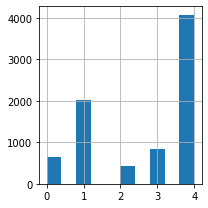

In [ ]:
from pylab import rcParams
rcParams['figure.figsize'] = 3, 3
df7['Product'].hist(); 
plt.tight_layout() 
plt.show() 

## 3. Prepare training and validation data


In [ ]:
X_train_raw=df7.loc[:, 'complaint']
X_train_raw=np.array(X_train_raw)

print(X_train_raw.dtype)
print(type(X_train_raw))
print(np.shape(X_train_raw))
print(X_train_raw[0:3])

object
<class 'numpy.ndarray'>
(8000,)
["I have a XXXX loan with Ocwen Loan Servicing. Back in XX/XX/XXXX, I applied for a loan modification and refused the offer. I did not send the paperwork back nor did I agree to the terms verbally. I continued to make my payments every month in the amount of XXXX. After I told them that I was trying to refinance my loan, the company begin an harassment everyone month, when they did not receive my payment after the XXXX day of the month. The company held my XX/XX/XXXX payment because they said that I was on the loan modification program and I continued to tell them that I have never accepted so, they withheld my payment and did not post to my account and reported to the credit bureau that I was late so, now my credit has dropped points due to their mistake and their retaliation against something that I would not agree to them. This company is a very dishonest company and they are bullying their customers and will take any measure to have them stay 

In [ ]:
y_train=df7.loc[:, 'Product']
y_train=np.array(y_train)

print(y_train.dtype)
print(type(y_train))
print(np.shape(y_train))
print(y_train[0:3])

int64
<class 'numpy.ndarray'>
(8000,)
[4 4 4]


##  4. Build BERT model

In [ ]:
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string)
preprocessor = hub.KerasLayer(
    "https://tfhub.dev/tensorflow/bert_multi_cased_preprocess/3")
encoder_inputs = preprocessor(text_input)
encoder = hub.KerasLayer(
    "https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/4",
    trainable=True)
outputs = encoder(encoder_inputs)      # [batch_size, 768].
out=Dense(16, activation='relu')(outputs["pooled_output"])
output=Dense(5, activation='softmax')(out)
model = tf.keras.Model(text_input, output)

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None,)]            0           []                               
                                                                                                  
 keras_layer (KerasLayer)       {'input_type_ids':   0           ['input_1[0][0]']                
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128),                                                          
                                 'input_word_ids':                                                
                                (None, 128)}                                                  

### Check how BERT works 

In [ ]:
sentences = tf.constant(["今回の彼の活躍は称賛に値する","His success this time is commendable","他这次的成功值得称赞"])
print(model(sentences).shape)
model(sentences)

(3, 5)


<tf.Tensor: shape=(3, 5), dtype=float32, numpy=
array([[0.0249191 , 0.38669425, 0.16490611, 0.20694798, 0.21653248],
       [0.02444271, 0.38796607, 0.21414709, 0.14414147, 0.22930267],
       [0.04571471, 0.34074447, 0.18099886, 0.21588147, 0.2166605 ]],
      dtype=float32)>

## 5. Train the model

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
t=time.time()

history = model.fit(X_train_raw, y_train, epochs=10, batch_size=16, validation_split=0.25)

t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict')

Epoch 1/10
375/375 [==============================] - 87s 195ms/step - loss: 0.8177 - accuracy: 0.7237 - val_loss: 0.5394 - val_accuracy: 0.8285
Epoch 2/10
375/375 [==============================] - 72s 192ms/step - loss: 0.4829 - accuracy: 0.8368 - val_loss: 0.4731 - val_accuracy: 0.8495
Epoch 3/10
375/375 [==============================] - 72s 192ms/step - loss: 0.3514 - accuracy: 0.8745 - val_loss: 0.4559 - val_accuracy: 0.8570
Epoch 4/10
375/375 [==============================] - 72s 193ms/step - loss: 0.2781 - accuracy: 0.9002 - val_loss: 0.4369 - val_accuracy: 0.8530
Epoch 5/10
375/375 [==============================] - 72s 193ms/step - loss: 0.2128 - accuracy: 0.9238 - val_loss: 0.4360 - val_accuracy: 0.8655
Epoch 6/10
375/375 [==============================] - 72s 193ms/step - loss: 0.1668 - accuracy: 0.9403 - val_loss: 0.4968 - val_accuracy: 0.8660
Epoch 7/10
375/375 [==============================] - 72s 192ms/step - loss: 0.1204 - accuracy: 0.9565 - val_loss: 0.4773 - val_ac

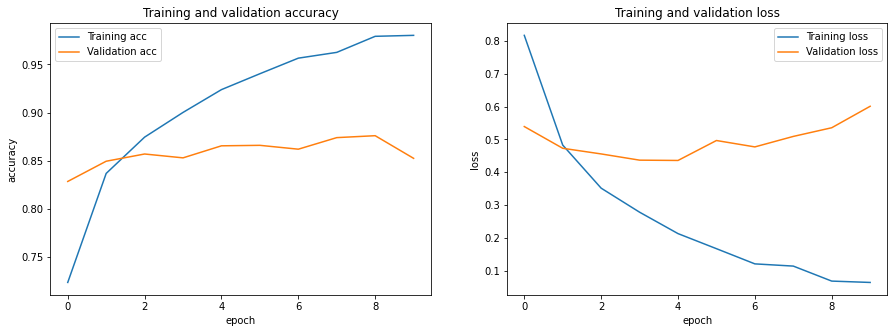

In [ ]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.plot(epochs, acc, label='Training acc')
plt.plot(epochs, val_acc, label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend()
            
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()

plt.show()

## 6. Evaluate the model with 1000 samples

In [ ]:
X_test_raw=df5.loc[:, 'complaint']
X_test_raw=np.array(X_test_raw)

print(X_test_raw.dtype)
print(type(X_test_raw))
print(np.shape(X_test_raw))
print(X_test_raw[0:3])

object
<class 'numpy.ndarray'>
(1000,)
['Two overdraft fees for two transaction that were not pay by the bank those two transactions came in at XXXX XXXX  and at XXXX XXXX I had over one thousand dollars deposited from payroll. I was charged two fee when the bank didnt pay for my two automatic payments that came out of the account'
 'In XX/XX/XXXX I bought my first home, a townhouse in XXXX, MA. The mortgage was an adjustable rate, interest only, no income verification with server refinance penalties. Originally the loan was though XXXX XXXX, but latter taken over by Wells Fargo. Knowing what I know now, I should have never been put in such a mortgage. My credit score was XXXX and I had a good paying job with the ability to put down 20 %. It took a year before the reality of this mortgage came to light. To make matters worse the automobile industry went through great financial trouble and my position was eliminated.\n\nThe next decade was a series of negotiations with Wells Fargo and t

In [ ]:
y_test=df5.loc[:, 'Product']
y_test=np.array(y_test)

print(y_test.dtype)
print(type(y_test))
print(np.shape(y_test))
print(y_test[0:3])

int64
<class 'numpy.ndarray'>
(1000,)
[1 4 4]


In [ ]:
X_test_raw.shape

(1000,)

In [ ]:
y_test.shape

(1000,)

In [ ]:
model.evaluate(X_test_raw, y_test)

32/32 [==============================] - 5s 137ms/step - loss: 0.5624 - accuracy: 0.8640


[0.56236732006073, 0.8640000224113464]

## 7. Confirm accuracy with Japanese text data

In [ ]:
Ja=['テキサス銀行（オクラホマ銀行）とのVA住宅ローンを持っていた... .XX / XX/XXXXで借り換え....エスクローの払い戻しはウェブサイトごとにXX/XX/XXXXでリリースされました....私はXXで彼らに連絡しました/ XX / XXXXで、小切手はXX / XX/XXXXに郵送されると言われました....XX/ XX / XXXXに呼び出され、XXXXの場所から北XXXXの私の家に郵送されたことを確認しました... 1週間待ったチェックなし...BOTと呼ばれるのは待ち続けるように言われました....XX/ XX/XXXXとXX/XX / XXXXにコールバックされ、同じことをただ待つように言われました....私は要求しました支払いを停止し、新しい小切手が切られ、さらに30日待つ必要があるかどうかを尋ねられました....最後の2回の電話で上司と話すように要求されましたが、同じ日に折り返し電話を受けると言われました。 ..電話を受けたことがない....BOTに2つの正式な苦情を申し立てており、それらに関して折り返し電話を受けることになっていた.....まだ電話を受けていない.......今日は今日です36と私は解決策なしで走り回っています「彼らが郵送した小切手\'\'をキャンセルし、さらに30日待ちます... ..私が求めているのは、小切手を受け取るか、1つを再カットして一晩中受け取ることができるオプションです。\ n \ nありがとうございます']

In [ ]:
t=time.time()

pre=model.predict(Ja)

t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict')

print(pre)

0.79963 Seconds to predict
[[0.00225021 0.00327002 0.00105914 0.00435813 0.9890625 ]]


In [ ]:
prediction=np.argmax(pre, axis=-1)
prediction

array([4])

In [ ]:
list(lab.inverse_transform(prediction))

['Mortgage']

This code is solely for educational purpose. The code cannot be used for investments or busineeses in practice. TOSHI STATS Co.,Ltd. and I do not accept any responsibility or liability for loss or damage occasioned to any person or property through using materials, instructions, methods, algorithm or ideas contained herein, or acting or refraining from acting as a result of such use. TOSHI STATS Co.,Ltd. and I expressly disclaim all implied warranties, including merchantability or fitness for any particular purpose. There will be no duty on TOSHI STATS Co.,Ltd. and me to correct any errors or defects in the codes and the software.¶

Copyright © 2022 ToshiStats Co.,Ltd. All right reserved